[*********************100%***********************]  1 of 1 completed
Epoch 1/20
44/44 [==============================] - 2s 7ms/step - loss: 0.0346
Epoch 2/20
44/44 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 3/20
44/44 [==============================] - 0s 5ms/step - loss: 4.9298e-04
Epoch 4/20
44/44 [==============================] - 0s 5ms/step - loss: 4.1950e-04
Epoch 5/20
44/44 [==============================] - 0s 6ms/step - loss: 3.8643e-04
Epoch 6/20
44/44 [==============================] - 0s 7ms/step - loss: 3.5385e-04
Epoch 7/20
44/44 [==============================] - 0s 5ms/step - loss: 3.3693e-04
Epoch 8/20
44/44 [==============================] - 0s 5ms/step - loss: 3.2186e-04
Epoch 9/20
44/44 [==============================] - 0s 5ms/step - loss: 3.1816e-04
Epoch 10/20
44/44 [==============================] - 0s 5ms/step - loss: 2.9663e-04
Epoch 11/20
44/44 [==============================] - 0s 7ms/step - loss: 3.0984e-04
Epoch 12/20
44/44 [=====

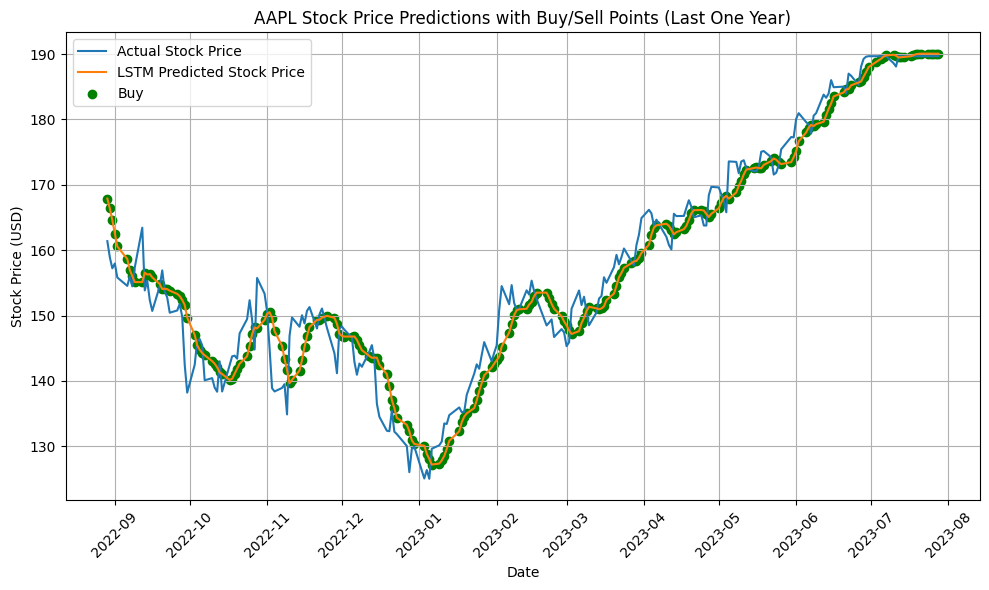

In [4]:
import random
import warnings
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yfinance as yf
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter("ignore")

SEED_VALUE = 42
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)

# Data Cleaning
# Handle Missing Data
dataset = dataset.dropna()  # Remove rows with missing data

# Remove Duplicates
dataset = dataset[~dataset.index.duplicated(keep='first')]

# Handle Outliers (Clipping values)
lower_bound = 0  # Define lower bound for clipping
upper_bound = np.percentile(dataset['Close'], 99)  # Define upper bound for clipping (99th percentile)
dataset['Close'] = np.clip(dataset['Close'], lower_bound, upper_bound)

# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


# Function to create sequences for LSTM models
def create_dataset(dataset, time_steps=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time_steps, 0])
    return np.array(data_X), np.array(data_Y)


# Define sequence length
sequence_length = 20

# Create sequences for LSTM models
X_train, y_train = create_dataset(train_data, sequence_length)
X_test, y_test = create_dataset(test_data, sequence_length)


# Build the LSTM model
def build_lstm_model(lr):
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    lstm_model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')
    return lstm_model


# # Define hyperparameter grid for grid search
# param_grid = {
#     'learning_rate': [0.001, 0.01, 0.1],
#     'epochs': [10, 20, 30],
#     'batch_size': [16, 32, 64]
# }
# 
# best_params = None
# best_rmse = float('inf')
# 
# # Grid search for best hyperparameters
# for params in ParameterGrid(param_grid):
#     lstm_model = build_lstm_model(lr=params['learning_rate'])
#     lstm_model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
#     lstm_predictions = lstm_model.predict(X_test)
#     lstm_predictions = scaler.inverse_transform(lstm_predictions)
#     lstm_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], lstm_predictions))
# 
#     if lstm_rmse < best_rmse:
#         best_rmse = lstm_rmse
#         best_params = params
# 
# print("Best hyperparameters:")
# print(best_params)
# 
# # Build and train the LSTM model with best hyperparameters
# lstm_model = build_lstm_model(lr=best_params['learning_rate'])
# lstm_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

# Delete this part
chosen_learning_rate = 0.001
chosen_epochs = 20
chosen_batch_size = 32
lstm_model = build_lstm_model(lr=chosen_learning_rate)
lstm_model.fit(X_train, y_train, epochs=chosen_epochs, batch_size=chosen_batch_size, verbose=1)

# Generate predictions for the LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)


# Function to calculate Theil U statistic
def theil_u_statistic(actual, predicted, naive):
    mse_actual = mean_squared_error(actual, naive)
    mse_predicted = mean_squared_error(actual, predicted)
    theil_u = np.sqrt(mse_predicted / mse_actual)
    return theil_u


# Generate naive predictions (using the last value in the training set)
naive_predictions = np.full_like(y_test, y_train[-1])

# Calculate indexes
lstm_rmse = np.sqrt(mean_squared_error(data[train_size + sequence_length:], lstm_predictions))
lstm_mae = mean_absolute_error(data[train_size + sequence_length:], lstm_predictions)
lstm_r2 = r2_score(data[train_size + sequence_length:], lstm_predictions)
lstm_mape = mean_absolute_percentage_error(data[train_size + sequence_length:], lstm_predictions)
lstm_theil_u = theil_u_statistic(data[train_size + sequence_length:], lstm_predictions, naive_predictions)

print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R2: {lstm_r2}")
print(f"MAPE: {lstm_mape:.2f}%")
print(f"Theil U statistic : {lstm_theil_u:.2f}")

lstm_predictions_list = lstm_predictions.flatten().tolist()


# Function to get price direction (rise or fall) from predictions
def get_price_direction(predictions):
    price_direction = np.zeros_like(predictions)
    price_direction[1:] = np.sign(predictions[1:] - predictions[:-1])
    return price_direction


# Get data for the last one year
one_year_ago = datetime.now() - timedelta(days=365)
one_year_data = dataset[dataset.index >= one_year_ago]

# Rescale the one-year data for plotting
one_year_data_scaled = scaler.transform(one_year_data['Close'].values.reshape(-1, 1))

# Create sequences for LSTM models for the one-year data
X_one_year, y_one_year = create_dataset(one_year_data_scaled, sequence_length)

# Generate predictions for the LSTM model on the one-year data
lstm_predictions_one_year = lstm_model.predict(X_one_year)
lstm_predictions_one_year = scaler.inverse_transform(lstm_predictions_one_year)

# Get price direction from LSTM predictions on the one-year data
lstm_price_direction_one_year = get_price_direction(lstm_predictions_one_year)

# Initialize variables for the trading strategy for the one-year period
initial_balance = 1000  # Initial balance (USD)
balance = initial_balance
stocks = 0
N = len(lstm_price_direction_one_year)  # Use the one-year price direction data

# Implement the trading strategy for the one-year period
for i in range(N):
    if lstm_price_direction_one_year[i] == 1:  # Predicted price will rise
        stocks_to_buy = int(balance / one_year_data['Close'][i + sequence_length])
        stocks += stocks_to_buy
        balance -= stocks_to_buy * one_year_data['Close'][i + sequence_length]
    elif lstm_price_direction_one_year[i] == -1:  # Predicted price will fall
        balance += stocks * one_year_data['Close'][i + sequence_length]
        stocks = 0

# Calculate profit or loss at the end of the one-year period
final_balance = balance + stocks * one_year_data['Close'][-1]
profit_or_loss = final_balance - initial_balance

print(f"Initial Balance: ${initial_balance}")
print(f"Final Balance: ${final_balance:.2f}")
print(f"Profit or Loss: ${profit_or_loss:.2f}")

# Plot the predictions with buy/sell points for the one-year period
plt.figure(figsize=(10, 6))

plt.plot(one_year_data.index[sequence_length:], one_year_data['Close'][sequence_length:], label='Actual Stock Price')
plt.plot(one_year_data.index[sequence_length:], lstm_predictions_one_year, label='LSTM Predicted Stock Price')
plt.scatter(one_year_data.index[sequence_length:], lstm_predictions_one_year, marker='o', color='g',
            label='Buy' if lstm_price_direction_one_year[-1] == 1 else 'Sell')

plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.title(f'{ticker} Stock Price Predictions with Buy/Sell Points (Last One Year)')
plt.legend()
plt.grid(True)

# Format x-axis ticks to show one month intervals
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()

# Add more descriptive labels to the X and Y axes
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')

plt.show()
